In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from datetime import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('float_format', '{:f}'.format)

In [60]:
def get_cols(df: pd.DataFrame) -> tuple:
    numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
    categorical_columns = df.select_dtypes(exclude=np.number).columns.tolist()

    return numeric_columns, categorical_columns

zona_departamento = {
    'Norte': ['LAMBAYEQUE', 'CAJAMARCA', 'PIURA', 'TUMBES', 'LA LIBERTAD', 'AMAZONAS', 'SAN MARTIN', 'LORETO'],
    'Centro': ['JUNIN', 'ANCASH', 'HUANUCO', 'HUANCAVELICA', 'PASCO', 'AYACUCHO', 'UCAYALI'],
    'Sur': ['AREQUIPA', 'MOQUEGUA', 'TACNA', 'CUSCO', 'PUNO', 'MADRE DE DIOS', 'ICA', 'APURIMAC', 'LIMA', 'CALLAO']
}
departamento_a_region = { v: k for k, values in zona_departamento.items() for v in values}

def asignar_region(departamento):
    return departamento_a_region.get(departamento, 'DESCONOCIDO')

# *balances*

In [ ]:
df_balances = (
    pd.read_csv('../data/raw/balances.csv')
    # [['PERIODO','ID','CANT_EMP_NEG','CANT_EMP_CONS','CANT_EMP_HIPOT','SALDO_MED_EMP','SALDO_PEQ_EMP','SALDO_MIC_EMP','SALDO_CONS_REV','SALDO_CONS_NO_REV','SALDO_HIPOT','SALDO_VENCIDO']]
)
df_balances['PERIODO'] = df_balances['PERIODO'].astype(str)

"""
PERIODO - Periodo de extracción de los datos
ID - Identificador único

CANT_EMP_NEG - Cantidad de empresas de negocio
CANT_EMP_CONS - Cantidad de empresas de consumo
CANT_EMP_HIPOT - Cantidad de empresas hipotecario
    * last
    * variable para ver si cerro o abrio empresas en los ultimos 9 meses

SALDO_MED_EMP - Saldo en mediana empresa
SALDO_PEQ_EMP - Saldo en pequeña empresa
SALDO_MIC_EMP - Saldo en micro empresa
    * categorica para saber que tipo de empresa tiene
    * last
    * variacion promedio de los saldos en los saldos que tiene

SALDO_CONS_REV - Saldo Consumo revolvente
SALDO_CONS_NO_REV - Saldo Consumo NO revolvente
    
SALDO_HIPOT - Saldo en hipotecario
SALDO_VENCIDO - Saldo vencido

CANT_EMP_DOL_NEG - Cantidad de empresas de negocios en dólares
SALDO_DOLA_NEG - Saldo en dólares de negocio
CANT_EMP_DOL_CONS - Cantidad de empresas de consumo en dólares
SALDO_DOLA_CONS - Saldo en dólares de consumo
CANT_EMP_DOL_HIPOT - Cantidad de empresas de hipotecario en dólares
SALDO_DOLA_HIPOT - Saldo en dólares de hipotecario
MAX_LINEA_DISP_U6M - Línea Máxima disponible en los últimos 6 meses
"""
df_balances.dtypes


In [ ]:
df_balances.isna().sum()

In [ ]:
# features = df_balances.select_dtypes(include=np.float64).columns

# r = int(math.sqrt(len(features)))
# c = len(features)//r + 1

# it = 1
# plt.figure(figsize=(18, 6))
# plt.suptitle("Visualizing columns with NaN, before and after imputation")
# for i, col in list(enumerate(features)):
#     plt.subplot(r, c, it)
#     if df_balances[col].dtype=='object':
#         sns.countplot(x=df_balances[col])
#     else:
#         sns.kdeplot(df_balances[col], label='original', linewidth=2, color='blue', alpha=0.5)
#         # sns.kdeplot(df_balances_imputed[col], label='imputed', linestyle='--', linewidth=2, color='red', alpha=0.5)
#         plt.grid()
#         plt.legend()
#     it += 1
# plt.tight_layout()
# plt.show()

In [ ]:
df_balances['SALDO_EMP_TOTAL'] = df_balances['SALDO_MED_EMP'] + df_balances['SALDO_PEQ_EMP'] + df_balances['SALDO_MIC_EMP'] + df_balances['SALDO_HIPOT']
df_balances['SALDO_EMP_TOTAL-VENCIDO'] = df_balances['SALDO_EMP_TOTAL'] - df_balances['SALDO_VENCIDO']
df_balances['SALDO_REV_NO_REV-VENCIDO'] = df_balances['SALDO_CONS_REV'] + df_balances['SALDO_CONS_NO_REV'] - df_balances['SALDO_VENCIDO']
df_balances['SALDO_TOTAL-VENCIDO'] = df_balances['SALDO_EMP_TOTAL'] + df_balances['SALDO_CONS_REV'] + df_balances['SALDO_CONS_NO_REV'] - df_balances['SALDO_VENCIDO']

df_balances['PROXY_MOROSIDAD_1'] = df_balances['SALDO_VENCIDO'] / df_balances['SALDO_EMP_TOTAL']
df_balances['PROXY_MOROSIDAD_2'] = df_balances['SALDO_VENCIDO'] / (df_balances['SALDO_EMP_TOTAL'] + df_balances['SALDO_CONS_REV'] + df_balances['SALDO_CONS_NO_REV'])
df_balances['PROXY_MOROSIDAD_3'] = df_balances['SALDO_VENCIDO'] / (df_balances['SALDO_CONS_REV'] + df_balances['SALDO_CONS_NO_REV'])

In [ ]:
# 'SALDO_EMP_TOTAL', 'SALDO_PEQ_EMP', 'SALDO_MED_EMP', 'SALDO_MIC_EMP', 'SALDO_CONS_REV', 'SALDO_CONS_NO_REV', 'SALDO_HIPOT', 'SALDO_VENCIDO'

for col in ['SALDO_EMP_TOTAL', 'SALDO_EMP_TOTAL-VENCIDO', 'SALDO_REV_NO_REV-VENCIDO', 'SALDO_TOTAL-VENCIDO']:
    print(col)
    df_balances[f'VAR_{col}_1'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.pct_change(periods=1))
    df_balances[f'VAR_{col}_MA3'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.pct_change(periods=1).rolling(window=3).mean())
    # df_balances[f'VAR_{col}_MA6'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.pct_change(periods=1).rolling(window=6).mean())
    df_balances[f'VAR_{col}_MA8'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.pct_change(periods=1).rolling(window=8).mean())

    df_balances[f'DIFF_{col}_1'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.diff(periods=1))
    df_balances[f'DIFF_{col}_MA3'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.diff(periods=1).rolling(window=3).mean())
    # df_balances[f'DIFF_{col}_MA6'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.diff(periods=1).rolling(window=6).mean())
    df_balances[f'DIFF_{col}_MA8'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.diff(periods=1).rolling(window=8).mean())
    
for col in ['SALDO_PEQ_EMP', 'SALDO_MED_EMP', 'SALDO_MIC_EMP'] + ['CANT_EMP_NEG', 'CANT_EMP_CONS', 'CANT_EMP_HIPOT']:
    print(col)
    df_balances[f'{col}_FLAG'] = df_balances[f'{col}'].apply(lambda x: True if x != 0 else False)

df_balances.head(9*4)

In [ ]:
df_balances.to_parquet('../data/processed/balances.gzip', compression='gzip')

In [ ]:

# df_balances['CANT_EMP_TOTAL'] = df_balances['CANT_EMP_NEG'] + df_balances['CANT_EMP_CONS'] + df_balances['CANT_EMP_HIPOT']    # ? las empresas son excluyentes?

In [ ]:
# df_balances.head(50)

In [ ]:
# list(df_balances['ID'].unique())

In [ ]:
df_balances.describe()

In [ ]:
df_balances.loc[df_balances['ID'] == '5da41258ad18492ea3aac6cc6c1e7a32']

In [ ]:
df_balances.dtypes

In [ ]:
df_balances.groupby('ID').agg({'PERIODO': 'unique'})

In [ ]:
plt.hist(df_balances['ID'].value_counts().reset_index())
plt.show()

In [ ]:
df_balances.isnull().sum() / len(df_balances)

In [ ]:
df_aux = df_balances.copy().replace(0, np.nan)
msno.matrix(df_aux, figsize=(10, 5))

In [3]:
df_balances = pd.read_parquet('../data/processed/balances.gzip')
df_balances.head(9*3)

,PERIODO,ID,CANT_EMP_NEG,CANT_EMP_CONS,CANT_EMP_HIPOT,SALDO_MED_EMP,SALDO_PEQ_EMP,SALDO_MIC_EMP,SALDO_CONS_REV,SALDO_CONS_NO_REV,SALDO_HIPOT,SALDO_VENCIDO,CANT_EMP_DOL_NEG,SALDO_DOLA_NEG,CANT_EMP_DOL_CONS,SALDO_DOLA_CONS,CANT_EMP_DOL_HIPOT,SALDO_DOLA_HIPOT,MAX_LINEA_DISP_U6M,SALDO_EMP_TOTAL,SALDO_EMP_TOTAL-VENCIDO,SALDO_REV_NO_REV-VENCIDO,SALDO_TOTAL-VENCIDO,VAR_SALDO_EMP_TOTAL_1,VAR_SALDO_EMP_TOTAL_MA3,VAR_SALDO_EMP_TOTAL_MA8,DIFF_SALDO_EMP_TOTAL_1,DIFF_SALDO_EMP_TOTAL_MA3,DIFF_SALDO_EMP_TOTAL_MA8,VAR_SALDO_EMP_TOTAL-VENCIDO_1,VAR_SALDO_EMP_TOTAL-VENCIDO_MA3,VAR_SALDO_EMP_TOTAL-VENCIDO_MA8,DIFF_SALDO_EMP_TOTAL-VENCIDO_1,DIFF_SALDO_EMP_TOTAL-VENCIDO_MA3,DIFF_SALDO_EMP_TOTAL-VENCIDO_MA8,VAR_SALDO_REV_NO_REV-VENCIDO_1,VAR_SALDO_REV_NO_REV-VENCIDO_MA3,VAR_SALDO_REV_NO_REV-VENCIDO_MA8,DIFF_SALDO_REV_NO_REV-VENCIDO_1,DIFF_SALDO_REV_NO_REV-VENCIDO_MA3,DIFF_SALDO_REV_NO_REV-VENCIDO_MA8,VAR_SALDO_TOTAL-VENCIDO_1,VAR_SALDO_TOTAL-VENCIDO_MA3,VAR_SALDO_TOTAL-VENCIDO_MA8,DIFF_SALDO_TOTAL-VENCIDO_1,DIFF_SALDO_TOTAL-VENCIDO_MA3,DIFF_SALDO_TOTAL-VENCIDO_MA8,SALDO_PEQ_EMP_FLAG,SALDO_MED_EMP_FLAG,SALDO_MIC_EMP_FLAG,CANT_EMP_NEG_FLAG,CANT_EMP_CONS_FLAG,CANT_EMP_HIPOT_FLAG
0,202301,858130171a01415f93d40802fc9e192d,1,0,0,0.000000,0.000000,405.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,405.000000,405.000000,0.000000,405.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,False,False
1,202302,858130171a01415f93d40802fc9e192d,1,0,0,0.000000,0.000000,346.566600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,346.566600,346.566600,0.000000,346.566600,-0.144280,NaN,NaN,-58.433400,NaN,NaN,-0.144280,NaN,NaN,-58.433400,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,-0.144280,NaN,NaN,-58.433400,NaN,NaN,False,False,True,True,False,False
2,202303,858130171a01415f93d40802fc9e192d,1,0,0,0.000000,0.000000,283.086900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,283.086900,283.086900,0.000000,283.086900,-0.183167,NaN,NaN,-63.479700,NaN,NaN,-0.183167,NaN,NaN,-63.479700,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,-0.183167,NaN,NaN,-63.479700,NaN,NaN,False,False,True,True,False,False
3,202304,858130171a01415f93d40802fc9e192d,1,0,0,0.000000,0.000000,217.987200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,217.987200,217.987200,0.000000,217.987200,-0.229964,-0.185804,NaN,-65.099700,-62.337600,NaN,-0.229964,-0.185804,NaN,-65.099700,-62.337600,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,-0.229964,-0.185804,NaN,-65.099700,-62.337600,NaN,False,False,True,True,False,False
4,202305,858130171a01415f93d40802fc9e192d,1,0,0,0.000000,0.000000,148.942800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,148.942800,148.942800,0.000000,148.942800,-0.316736,-0.243289,NaN,-69.044400,-65.874600,NaN,-0.316736,-0.243289,NaN,-69.044400,-65.874600,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,-0.316736,-0.243289,NaN,-69.044400,-65.874600,NaN,False,False,True,True,False,False
5,202306,858130171a01415f93d40802fc9e192d,1,0,0,0.000000,0.000000,76.512600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,76.512600,76.512600,0.000000,76.512600,-0.486295,-0.344332,NaN,-72.430200,-68.858100,NaN,-0.486295,-0.344332,NaN,-72.430200,-68.858100,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,-0.486295,-0.344332,NaN,-72.430200,-68.858100,NaN,False,False,True,True,False,False
6,202307,858130171a01415f93d40802fc9e192d,1,1,0,0.000000,0.000000,1215.000000,0.000000,1826.041500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,1215.000000,1215.000000,1826.041500,3041.041500,14.879737,4.692235,NaN,1138.487400,332.337600,NaN,14.879737,4.692235,NaN,1138.487400,332.337600,NaN,inf,NaN,NaN,1826.041500,608.680500,NaN,38.745630,12.647533,NaN,

In [4]:
df_balances.columns

Index(['PERIODO', 'ID', 'CANT_EMP_NEG', 'CANT_EMP_CONS', 'CANT_EMP_HIPOT',
       'SALDO_MED_EMP', 'SALDO_PEQ_EMP', 'SALDO_MIC_EMP', 'SALDO_CONS_REV',
       'SALDO_CONS_NO_REV', 'SALDO_HIPOT', 'SALDO_VENCIDO', 'CANT_EMP_DOL_NEG',
       'SALDO_DOLA_NEG', 'CANT_EMP_DOL_CONS', 'SALDO_DOLA_CONS',
       'CANT_EMP_DOL_HIPOT', 'SALDO_DOLA_HIPOT', 'MAX_LINEA_DISP_U6M',
       'SALDO_EMP_TOTAL', 'SALDO_EMP_TOTAL-VENCIDO',
       'SALDO_REV_NO_REV-VENCIDO', 'SALDO_TOTAL-VENCIDO',
       'VAR_SALDO_EMP_TOTAL_1', 'VAR_SALDO_EMP_TOTAL_MA3',
       'VAR_SALDO_EMP_TOTAL_MA8', 'DIFF_SALDO_EMP_TOTAL_1',
       'DIFF_SALDO_EMP_TOTAL_MA3', 'DIFF_SALDO_EMP_TOTAL_MA8',
       'VAR_SALDO_EMP_TOTAL-VENCIDO_1', 'VAR_SALDO_EMP_TOTAL-VENCIDO_MA3',
       'VAR_SALDO_EMP_TOTAL-VENCIDO_MA8', 'DIFF_SALDO_EMP_TOTAL-VENCIDO_1',
       'DIFF_SALDO_EMP_TOTAL-VENCIDO_MA3', 'DIFF_SALDO_EMP_TOTAL-VENCIDO_MA8',
       'VAR_SALDO_REV_NO_REV-VENCIDO_1', 'VAR_SALDO_REV_NO_REV-VENCIDO_MA3',
       'VAR_SALDO_REV_NO_REV-VENC

In [5]:
df_balances_unirow = df_balances.groupby('ID').agg(
    {
        'CANT_EMP_NEG': ['max', 'last', 'min'],
        'CANT_EMP_CONS': ['max', 'last', 'min'],
        'CANT_EMP_HIPOT': ['max', 'last', 'min'],
        
        'SALDO_MED_EMP' : ['mean', 'median', 'last', 'min', 'max', 'first'],
        'SALDO_PEQ_EMP' : ['mean', 'median', 'last', 'min', 'max', 'first'],
        'SALDO_MIC_EMP' : ['mean', 'median', 'last', 'min', 'max', 'first'],
        'SALDO_CONS_REV' : ['mean', 'median', 'last', 'min', 'max', 'first'],
        'SALDO_CONS_NO_REV' : ['mean', 'median', 'last', 'min', 'max', 'first'],
        'SALDO_HIPOT' : ['mean', 'median', 'last', 'min', 'max', 'first'],
        'SALDO_VENCIDO' : ['mean', 'median', 'last', 'min', 'max', 'first'],

        'CANT_EMP_DOL_NEG' : ['mean', 'median', 'last', 'min', 'max', 'first'],
        'SALDO_DOLA_NEG' : ['mean', 'median', 'last', 'min', 'max', 'first'],
        'CANT_EMP_DOL_CONS' : ['mean', 'median', 'last', 'min', 'max', 'first'],
        'SALDO_DOLA_CONS' : ['mean', 'median', 'last', 'min', 'max', 'first'],
        'CANT_EMP_DOL_HIPOT' : ['mean', 'median', 'last', 'min', 'max', 'first'],
        'SALDO_DOLA_HIPOT' : ['mean', 'median', 'last', 'min', 'max', 'first'],
        'MAX_LINEA_DISP_U6M' : ['mean', 'median', 'last', 'min', 'max', 'first'],

        'SALDO_EMP_TOTAL': ['mean', 'last', 'max', 'min', 'median'],
        
        'VAR_SALDO_EMP_TOTAL_1' : ['mean', 'median'], 
        'VAR_SALDO_EMP_TOTAL_MA3' : ['mean', 'median'], 
        # 'VAR_SALDO_EMP_TOTAL_MA6' : ['mean', 'median'],
        'VAR_SALDO_EMP_TOTAL_MA8' : ['mean', 'median'], 
        
        'VAR_SALDO_EMP_TOTAL-VENCIDO_1' : ['mean', 'median'],
        'VAR_SALDO_EMP_TOTAL-VENCIDO_MA3' : ['mean', 'median'],
        # 'VAR_SALDO_EMP_TOTAL-VENCIDO_MA6' : ['mean', 'median'],
        'VAR_SALDO_EMP_TOTAL-VENCIDO_MA8' : ['mean', 'median'],
        
        'DIFF_SALDO_EMP_TOTAL_1' : ['mean', 'median'],
        'DIFF_SALDO_EMP_TOTAL_MA3' : ['mean', 'median'],
        # 'DIFF_SALDO_EMP_TOTAL_MA6' : ['mean', 'median'],
        'DIFF_SALDO_EMP_TOTAL_MA8' : ['mean', 'median'],

        'DIFF_SALDO_EMP_TOTAL-VENCIDO_1' : ['mean', 'median'],
        'DIFF_SALDO_EMP_TOTAL-VENCIDO_MA3' : ['mean', 'median'],
        # 'DIFF_SALDO_EMP_TOTAL-VENCIDO_MA6' : ['mean', 'median'],
        'DIFF_SALDO_EMP_TOTAL-VENCIDO_MA8' : ['mean', 'median'],

        'VAR_SALDO_REV_NO_REV-VENCIDO_1' : ['mean', 'median'],
        'VAR_SALDO_REV_NO_REV-VENCIDO_MA3' : ['mean', 'median'],
        # 'VAR_SALDO_REV_NO_REV-VENCIDO_MA6' : ['mean', 'median'],
        'VAR_SALDO_REV_NO_REV-VENCIDO_MA8' : ['mean', 'median'],

        'VAR_SALDO_TOTAL-VENCIDO_1' : ['mean', 'median'],
        'VAR_SALDO_TOTAL-VENCIDO_MA3' : ['mean', 'median'],
        # 'VAR_SALDO_TOTAL-VENCIDO_MA6' : ['mean', 'median'],
        'VAR_SALDO_TOTAL-VENCIDO_MA8' : ['mean', 'median'],

        # 'SALDO_PEQ_EMP_FLAG' : ['any'],
        # 'SALDO_MED_EMP_FLAG' : ['any'],
        # 'SALDO_MIC_EMP_FLAG' : ['any'],
        # 'CANT_EMP_NEG_FLAG' : ['any'],
        # 'CANT_EMP_CONS_FLAG' : ['any'],
        # 'CANT_EMP_HIPOT_FLAG' : ['any'],
    }
).replace([np.inf, -np.inf], np.nan).fillna(0)

df_balances_unirow.columns = ['_'.join(col) for col in df_balances_unirow.columns.values]
df_balances_unirow = df_balances_unirow.reset_index()

df_balances_unirow

,ID,CANT_EMP_NEG_max,CANT_EMP_NEG_last,CANT_EMP_NEG_min,CANT_EMP_CONS_max,CANT_EMP_CONS_last,CANT_EMP_CONS_min,CANT_EMP_HIPOT_max,CANT_EMP_HIPOT_last,CANT_EMP_HIPOT_min,SALDO_MED_EMP_mean,SALDO_MED_EMP_median,SALDO_MED_EMP_last,SALDO_MED_EMP_min,SALDO_MED_EMP_max,SALDO_MED_EMP_first,SALDO_PEQ_EMP_mean,SALDO_PEQ_EMP_median,SALDO_PEQ_EMP_last,SALDO_PEQ_EMP_min,SALDO_PEQ_EMP_max,SALDO_PEQ_EMP_first,SALDO_MIC_EMP_mean,SALDO_MIC_EMP_median,SALDO_MIC_EMP_last,SALDO_MIC_EMP_min,SALDO_MIC_EMP_max,SALDO_MIC_EMP_first,SALDO_CONS_REV_mean,SALDO_CONS_REV_median,SALDO_CONS_REV_last,SALDO_CONS_REV_min,SALDO_CONS_REV_max,SALDO_CONS_REV_first,SALDO_CONS_NO_REV_mean,SALDO_CONS_NO_REV_median,SALDO_CONS_NO_REV_last,SALDO_CONS_NO_REV_min,SALDO_CONS_NO_REV_max,SALDO_CONS_NO_REV_first,SALDO_HIPOT_mean,SALDO_HIPOT_median,SALDO_HIPOT_last,SALDO_HIPOT_min,SALDO_HIPOT_max,SALDO_HIPOT_first,SALDO_VENCIDO_mean,SALDO_VENCIDO_median,SALDO_VENCIDO_last,SALDO_VENCIDO_min,SALDO_VENCIDO_max,SALDO_VENCIDO_first,CANT_EMP_DOL_NEG_mean,CANT_EMP_DOL_NEG_median,CANT_EMP_DOL_NEG_last,CANT_EMP_DOL_NEG_min,CANT_EMP_DOL_NEG_max,CANT_EMP_DOL_NEG_first,SALDO_DOLA_NEG_mean,SALDO_DOLA_NEG_median,SALDO_DOLA_NEG_last,SALDO_DOLA_NEG_min,SALDO_DOLA_NEG_max,SALDO_DOLA_NEG_first,CANT_EMP_DOL_CONS_mean,CANT_EMP_DOL_CONS_median,CANT_EMP_DOL_CONS_last,CANT_EMP_DOL_CONS_min,CANT_EMP_DOL_CONS_max,CANT_EMP_DOL_CONS_first,SALDO_DOLA_CONS_mean,SALDO_DOLA_CONS_median,SALDO_DOLA_CONS_last,SALDO_DOLA_CONS_min,SALDO_DOLA_CONS_max,SALDO_DOLA_CONS_first,CANT_EMP_DOL_HIPOT_mean,CANT_EMP_DOL_HIPOT_median,CANT_EMP_DOL_HIPOT_last,CANT_EMP_DOL_HIPOT_min,CANT_EMP_DOL_HIPOT_max,CANT_EMP_DOL_HIPOT_first,SALDO_DOLA_HIPOT_mean,SALDO_DOLA_HIPOT_median,SALDO_DOLA_HIPOT_last,SALDO_DOLA_HIPOT_min,SALDO_DOLA_HIPOT_max,SALDO_DOLA_HIPOT_first,MAX_LINEA_DISP_U6M_mean,MAX_LINEA_DISP_U6M_median,MAX_LINEA_DISP_U6M_last,MAX_LINEA_DISP_U6M_min,MAX_LINEA_DISP_U6M_max,MAX_LINEA_DISP_U6M_first,SALDO_EMP_TOTAL_mean,SALDO_EMP_TOTAL_last,SALDO_EMP_TOTAL_max,SALDO_EMP_TOTAL_min,SALDO_EMP_TOTAL_median,VAR_SALDO_EMP_TOTAL_1_mean,VAR_SALDO_EMP_TOTAL_1_median,VAR_SALDO_EMP_TOTAL_MA3_mean,VAR_SALDO_EMP_TOTAL_MA3_median,VAR_SALDO_EMP_TOTAL_MA8_mean,VAR_SALDO_EMP_TOTAL_MA8_median,VAR_SALDO_EMP_TOTAL-VENCIDO_1_mean,VAR_SALDO_EMP_TOTAL-VENCIDO_1_median,VAR_SALDO_EMP_TOTAL-VENCIDO_MA3_mean,VAR_SALDO_EMP_TOTAL-VENCIDO_MA3_median,VAR_SALDO_EMP_TOTAL-VENCIDO_MA8_mean,VAR_SALDO_EMP_TOTAL-VENCIDO_MA8_median,DIFF_SALDO_EMP_TOTAL_1_mean,DIFF_SALDO_EMP_TOTAL_1_median,DIFF_SALDO_EMP_TOTAL_MA3_mean,DIFF_SALDO_EMP_TOTAL_MA3_median,DIFF_SALDO_EMP_TOTAL_MA8_mean,DIFF_SALDO_EMP_TOTAL_MA8_median,DIFF_SALDO_EMP_TOTAL-VENCIDO_1_mean,DIFF_SALDO_EMP_TOTAL-VENCIDO_1_median,DIFF_SALDO_EMP_TOTAL-VENCIDO_MA3_mean,DIFF_SALDO_EMP_TOTAL-VENCIDO_MA3_median,DIFF_SALDO_EMP_TOTAL-VENCIDO_MA8_mean,DIFF_SALDO_EMP_TOTAL-VENCIDO_MA8_median,VAR_SALDO_REV_NO_REV-VENCIDO_1_mean,VAR_SALDO_REV_NO_REV-VENCIDO_1_median,VAR_SALDO_REV_NO_REV-VENCIDO_MA3_mean,VAR_SALDO_REV_NO_REV-VENCIDO_MA3_median,VAR_SALDO_REV_NO_REV-VENCIDO_MA8_mean,VAR_SALDO_REV_NO_REV-VENCIDO_MA8_median,VAR_SALDO_TOTAL-VENCIDO_1_mean,VAR_SALDO_TOTAL-VENCIDO_1_median,VAR_SALDO_TOTAL-VENCIDO_MA3_mean,VAR_SALDO_TOTAL-VENCIDO_MA3_median,VAR_SALDO_TOTAL-VENCIDO_MA8_mean,VAR_SALDO_TOTAL-VENCIDO_MA8_median
0,00000ae64b2d4ea7b318f3caa49fb832,1,1,1,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26052.711556,25834.968000,23286.846500,23286.846500,28983.036500,28983.036500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [56]:
# plt.boxplot(df_balances_unirow['VAR_SALDO_TOTAL-VENCIDO_MA6_median'])

In [57]:
nc, cc = get_cols(df_balances_unirow)
df_balances_unirow[nc].std(numeric_only=True).reset_index().sort_values(by=0, ascending=False)

,index,0
95,SALDO_EMP_TOTAL_max,80173.564228
94,SALDO_EMP_TOTAL_last,70848.901986
97,SALDO_EMP_TOTAL_median,69892.524226
93,SALDO_EMP_TOTAL_mean,69015.638912
96,SALDO_EMP_TOTAL_min,60878.987456
...,...,...
56,CANT_EMP_DOL_NEG_first,0.027976
53,CANT_EMP_DOL_NEG_last,0.027020
52,CANT_EMP_DOL_NEG_median,0.026652
51,CANT_EMP_DOL_NEG_mean,0.025295


In [58]:

# corr_mat = df_balances_unirow[nc].corr(method='spearman')
# mask = np.tril(np.ones_like(corr_mat, dtype=bool))  # create a mask to hide the lower triangle of the heatmap
# plt.figure(figsize=(40, 40))
# sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, fmt='.2f', mask=mask)  # add the mask to the heatmap
# plt.title('Imputed Correlation Matrix')
# plt.show()

In [59]:
df_balances_unirow

,ID,CANT_EMP_NEG_max,CANT_EMP_NEG_last,CANT_EMP_NEG_min,CANT_EMP_CONS_max,CANT_EMP_CONS_last,CANT_EMP_CONS_min,CANT_EMP_HIPOT_max,CANT_EMP_HIPOT_last,CANT_EMP_HIPOT_min,SALDO_MED_EMP_mean,SALDO_MED_EMP_median,SALDO_MED_EMP_last,SALDO_MED_EMP_min,SALDO_MED_EMP_max,SALDO_MED_EMP_first,SALDO_PEQ_EMP_mean,SALDO_PEQ_EMP_median,SALDO_PEQ_EMP_last,SALDO_PEQ_EMP_min,SALDO_PEQ_EMP_max,SALDO_PEQ_EMP_first,SALDO_MIC_EMP_mean,SALDO_MIC_EMP_median,SALDO_MIC_EMP_last,SALDO_MIC_EMP_min,SALDO_MIC_EMP_max,SALDO_MIC_EMP_first,SALDO_CONS_REV_mean,SALDO_CONS_REV_median,SALDO_CONS_REV_last,SALDO_CONS_REV_min,SALDO_CONS_REV_max,SALDO_CONS_REV_first,SALDO_CONS_NO_REV_mean,SALDO_CONS_NO_REV_median,SALDO_CONS_NO_REV_last,SALDO_CONS_NO_REV_min,SALDO_CONS_NO_REV_max,SALDO_CONS_NO_REV_first,SALDO_HIPOT_mean,SALDO_HIPOT_median,SALDO_HIPOT_last,SALDO_HIPOT_min,SALDO_HIPOT_max,SALDO_HIPOT_first,SALDO_VENCIDO_mean,SALDO_VENCIDO_median,SALDO_VENCIDO_last,SALDO_VENCIDO_min,SALDO_VENCIDO_max,SALDO_VENCIDO_first,CANT_EMP_DOL_NEG_mean,CANT_EMP_DOL_NEG_median,CANT_EMP_DOL_NEG_last,CANT_EMP_DOL_NEG_min,CANT_EMP_DOL_NEG_max,CANT_EMP_DOL_NEG_first,SALDO_DOLA_NEG_mean,SALDO_DOLA_NEG_median,SALDO_DOLA_NEG_last,SALDO_DOLA_NEG_min,SALDO_DOLA_NEG_max,SALDO_DOLA_NEG_first,CANT_EMP_DOL_CONS_mean,CANT_EMP_DOL_CONS_median,CANT_EMP_DOL_CONS_last,CANT_EMP_DOL_CONS_min,CANT_EMP_DOL_CONS_max,CANT_EMP_DOL_CONS_first,SALDO_DOLA_CONS_mean,SALDO_DOLA_CONS_median,SALDO_DOLA_CONS_last,SALDO_DOLA_CONS_min,SALDO_DOLA_CONS_max,SALDO_DOLA_CONS_first,CANT_EMP_DOL_HIPOT_mean,CANT_EMP_DOL_HIPOT_median,CANT_EMP_DOL_HIPOT_last,CANT_EMP_DOL_HIPOT_min,CANT_EMP_DOL_HIPOT_max,CANT_EMP_DOL_HIPOT_first,SALDO_DOLA_HIPOT_mean,SALDO_DOLA_HIPOT_median,SALDO_DOLA_HIPOT_last,SALDO_DOLA_HIPOT_min,SALDO_DOLA_HIPOT_max,SALDO_DOLA_HIPOT_first,MAX_LINEA_DISP_U6M_mean,MAX_LINEA_DISP_U6M_median,MAX_LINEA_DISP_U6M_last,MAX_LINEA_DISP_U6M_min,MAX_LINEA_DISP_U6M_max,MAX_LINEA_DISP_U6M_first,SALDO_EMP_TOTAL_mean,SALDO_EMP_TOTAL_last,SALDO_EMP_TOTAL_max,SALDO_EMP_TOTAL_min,SALDO_EMP_TOTAL_median,VAR_SALDO_EMP_TOTAL_1_mean,VAR_SALDO_EMP_TOTAL_1_median,VAR_SALDO_EMP_TOTAL_MA3_mean,VAR_SALDO_EMP_TOTAL_MA3_median,VAR_SALDO_EMP_TOTAL_MA8_mean,VAR_SALDO_EMP_TOTAL_MA8_median,VAR_SALDO_EMP_TOTAL-VENCIDO_1_mean,VAR_SALDO_EMP_TOTAL-VENCIDO_1_median,VAR_SALDO_EMP_TOTAL-VENCIDO_MA3_mean,VAR_SALDO_EMP_TOTAL-VENCIDO_MA3_median,VAR_SALDO_EMP_TOTAL-VENCIDO_MA8_mean,VAR_SALDO_EMP_TOTAL-VENCIDO_MA8_median,DIFF_SALDO_EMP_TOTAL_1_mean,DIFF_SALDO_EMP_TOTAL_1_median,DIFF_SALDO_EMP_TOTAL_MA3_mean,DIFF_SALDO_EMP_TOTAL_MA3_median,DIFF_SALDO_EMP_TOTAL_MA8_mean,DIFF_SALDO_EMP_TOTAL_MA8_median,DIFF_SALDO_EMP_TOTAL-VENCIDO_1_mean,DIFF_SALDO_EMP_TOTAL-VENCIDO_1_median,DIFF_SALDO_EMP_TOTAL-VENCIDO_MA3_mean,DIFF_SALDO_EMP_TOTAL-VENCIDO_MA3_median,DIFF_SALDO_EMP_TOTAL-VENCIDO_MA8_mean,DIFF_SALDO_EMP_TOTAL-VENCIDO_MA8_median,VAR_SALDO_REV_NO_REV-VENCIDO_1_mean,VAR_SALDO_REV_NO_REV-VENCIDO_1_median,VAR_SALDO_REV_NO_REV-VENCIDO_MA3_mean,VAR_SALDO_REV_NO_REV-VENCIDO_MA3_median,VAR_SALDO_REV_NO_REV-VENCIDO_MA8_mean,VAR_SALDO_REV_NO_REV-VENCIDO_MA8_median,VAR_SALDO_TOTAL-VENCIDO_1_mean,VAR_SALDO_TOTAL-VENCIDO_1_median,VAR_SALDO_TOTAL-VENCIDO_MA3_mean,VAR_SALDO_TOTAL-VENCIDO_MA3_median,VAR_SALDO_TOTAL-VENCIDO_MA8_mean,VAR_SALDO_TOTAL-VENCIDO_MA8_median
0,00000ae64b2d4ea7b318f3caa49fb832,1,1,1,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26052.711556,25834.968000,23286.846500,23286.846500,28983.036500,28983.036500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

# *customers*

In [6]:
df_customers_imputed = pd.read_parquet('../data/raw/costumer_imputed_one_hot.gzip')

nodpto_cols = [col for col in df_customers_imputed if 'cat__NO_DEPARTAMENTO' in col]

df_customers_imputed['departamento'] = df_customers_imputed[nodpto_cols].idxmax(axis=1).str.replace('cat__NO_DEPARTAMENTO_', '')
df_customers_imputed['departamento'].value_counts()

nan              75744
LAMBAYEQUE       17353
AREQUIPA          7088
JUNIN             5966
CAJAMARCA         5787
ANCASH            4858
PASCO             4665
LA LIBERTAD       3441
TUMBES            3179
PIURA             2925
ICA               2825
PUNO              2013
HUANUCO           1914
CALLAO            1884
AYACUCHO          1827
HUANCAVELICA      1766
MADRE DE DIOS     1351
AMAZONAS          1216
TACNA             1215
SAN MARTIN        1133
UCAYALI           1062
LIMA               781
APURIMAC           674
LORETO             498
CUSCO              411
MOQUEGUA           396
Name: departamento, dtype: int64

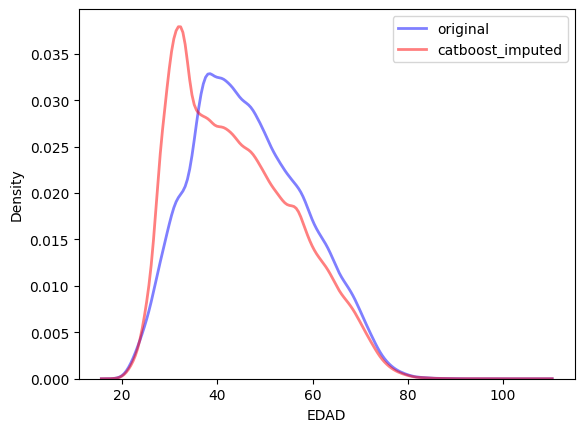

In [9]:
df_customers = (
    pd.read_csv('../data/raw/customers.csv')
    .assign(
        PER_BANCARIZACION = lambda row: row['PER_BANCARIZACION'].astype(str)
    )
    .assign(
        ANIO_BANCARIZACION = lambda row: row['PER_BANCARIZACION'].str[:4],
        MES_BANCARIZACION = lambda row: row['PER_BANCARIZACION'].str[5:7]
    )
    .assign(
        ANIO_BANCARIZACION = lambda row: row['ANIO_BANCARIZACION'].astype(int),
        MES_BANCARIZACION = lambda row: row['MES_BANCARIZACION'].astype(int),
        # FECHA_BANCARIZACION = lambda row: pd.to_datetime()
    )
    .drop(columns=['PER_BANCARIZACION', 'DE_CIIU', 'NO_PROVINCIA'])
)

sns.kdeplot(df_customers['EDAD'], label='original', linewidth=2, color='blue', alpha=0.5)
sns.kdeplot(df_customers_imputed['num__EDAD'], label='catboost_imputed', linewidth=2, color='red', alpha=0.5)
plt.legend()
plt.show()


In [10]:
df_customers.loc[lambda df : (df['MES_BANCARIZACION']) < 1 | (df['MES_BANCARIZACION'] > 12), ['MES_BANCARIZACION']] = 1
df_customers['FECHA_BANCARIZACION'] = pd.to_datetime(df_customers['ANIO_BANCARIZACION'].astype(str) + df_customers['MES_BANCARIZACION'].astype(str).str.zfill(2), format='%Y%m')
df_customers['CO_TIPO_SEXO'] = df_customers['CO_TIPO_SEXO'].astype('category')
df_customers['NO_DEPARTAMENTO'] = df_customers['NO_DEPARTAMENTO'].replace('nan', np.nan)
df_customers['NO_DEPARTAMENTO'] = df_customers['NO_DEPARTAMENTO'].astype('category')

df_customers['MESES_HASTA_ACTUAL'] = (datetime.now() - df_customers['FECHA_BANCARIZACION']) // pd.Timedelta(days=30)      # astype('<m8[M]')
df_customers = df_customers.drop(columns=['ANIO_BANCARIZACION', 'MES_BANCARIZACION', 'FECHA_BANCARIZACION'])
df_customers['EDAD'] = df_customers_imputed['num__EDAD']

print(df_customers.isna().sum())
display(df_customers)
print(df_customers.dtypes)

ID                        0
CO_TIPO_SEXO              0
EDAD                      0
NO_DEPARTAMENTO       75744
MESES_HASTA_ACTUAL        0
dtype: int64


,ID,CO_TIPO_SEXO,EDAD,NO_DEPARTAMENTO,MESES_HASTA_ACTUAL
0,8bd775237f2f4c7cae87c255e9e71d62,1,48.000000,CAJAMARCA,126
1,2409b242893e4ea4b7e6af1292030666,3,28.200000,NaN,75
2,65edb7eb9d144b2184ef76ec2c35cdf8,1,38.000000,NaN,192
3,2fef711096234036807b01a5a697a81c,1,61.000000,TACNA,217
4,796443da390d409ba3e7b775fde576cd,3,29.000000,LAMBAYEQUE,115
...,...,...,...,...,...
151967,54a73b9c515f46d19c0182e3f44f44fe,3,25.000000,NaN,27
151968,1df55d6b6af544b58312d68241a10e4f,3,32.000000,LAMBAYEQUE,63
151969,5dd4a95d877d4474a277173c6fe4d227,1,62.000000,NaN,217
151970,cbad53becdb042cfb98a992566ec0e94,2,51.000000,NaN,131


ID                      object
CO_TIPO_SEXO          category
EDAD                   float64
NO_DEPARTAMENTO       category
MESES_HASTA_ACTUAL       int64
dtype: object


In [11]:
df_customers.isna().sum()

ID                        0
CO_TIPO_SEXO              0
EDAD                      0
NO_DEPARTAMENTO       75744
MESES_HASTA_ACTUAL        0
dtype: int64

In [ ]:
# sns.kdeplot(df_customers['EDAD'])
# sns.kdeplot(df_customers['EDAD'].fillna(df_customers['EDAD'].median()))

In [ ]:
# # Fill NO_DEPARTAMENTO by KNN with 10 neighbors
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=10)

# df_customers['NO_DEPARTAMENTO'] = imputer.fit_transform(df_customers[['NO_DEPARTAMENTO']])

In [ ]:
# df_customers['REGION'] = df_customers['NO_DEPARTAMENTO'].apply(asignar_region)

In [64]:
print(df_customers['CO_TIPO_SEXO'].value_counts(normalize=True))
print(df_customers['NO_DEPARTAMENTO'].value_counts(normalize=True))
# print(df_customers['DE_CIIU'].value_counts(normalize=True))

2   0.344030
1   0.328903
3   0.327067
Name: CO_TIPO_SEXO, dtype: float64
LAMBAYEQUE      0.227646
AREQUIPA        0.092984
JUNIN           0.078265
CAJAMARCA       0.075917
ANCASH          0.063730
PASCO           0.061198
LA LIBERTAD     0.045141
TUMBES          0.041704
PIURA           0.038372
ICA             0.037060
PUNO            0.026408
HUANUCO         0.025109
CALLAO          0.024715
AYACUCHO        0.023968
HUANCAVELICA    0.023167
MADRE DE DIOS   0.017723
AMAZONAS        0.015952
TACNA           0.015939
SAN MARTIN      0.014863
UCAYALI         0.013932
LIMA            0.010246
APURIMAC        0.008842
LORETO          0.006533
CUSCO           0.005392
MOQUEGUA        0.005195
Name: NO_DEPARTAMENTO, dtype: float64


<Axes: >

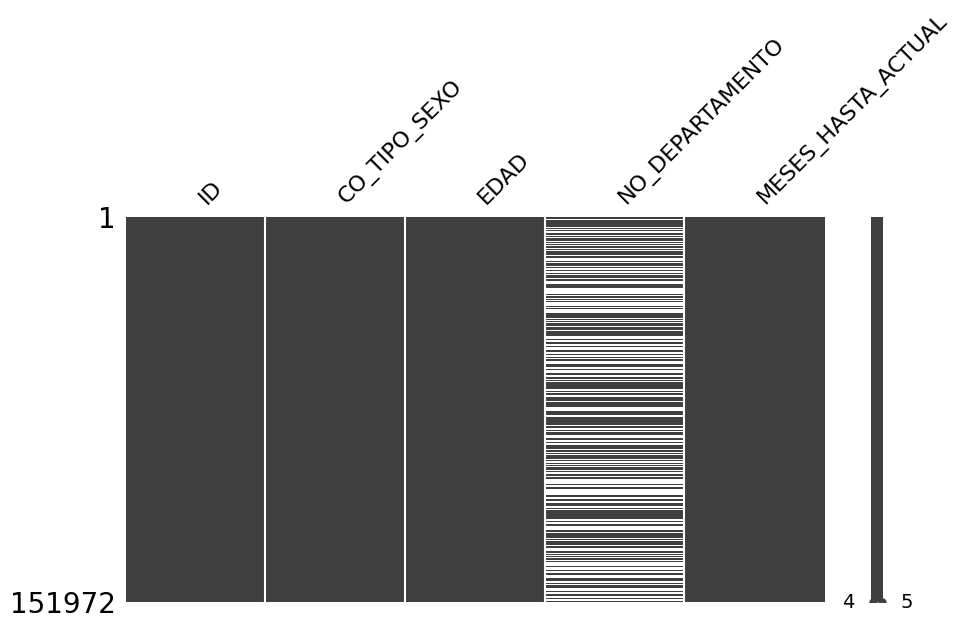

In [65]:
msno.matrix(df_customers, figsize=(10, 5))

# *JOIN*

In [32]:
df_join = df_customers.merge(
    df_balances_unirow, how='left', on='ID'
)
df_join['NO_DEPARTAMENTO'] = df_join['NO_DEPARTAMENTO'].astype(str).replace('nan', np.nan)

In [33]:
df_join['NO_DEPARTAMENTO'].isna().sum()

75744

In [34]:
print(len(list(df_join['NO_DEPARTAMENTO'].unique())) - 1)

25


In [35]:
# sns.kdeplot(df_join['EDAD'], shade=True)

In [36]:
df_join.isna().sum()

ID                                        0
CO_TIPO_SEXO                              0
EDAD                                      0
NO_DEPARTAMENTO                       75744
MESES_HASTA_ACTUAL                        0
                                      ...  
VAR_SALDO_TOTAL-VENCIDO_1_median          0
VAR_SALDO_TOTAL-VENCIDO_MA3_mean          0
VAR_SALDO_TOTAL-VENCIDO_MA3_median        0
VAR_SALDO_TOTAL-VENCIDO_MA8_mean          0
VAR_SALDO_TOTAL-VENCIDO_MA8_median        0
Length: 139, dtype: int64

In [42]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
df_encoded = pd.DataFrame(encoder.fit_transform(df_join[['NO_DEPARTAMENTO']]), columns=['NO_DEPARTAMENTO'])

nc, cc = get_cols(df_join)
df_combined = pd.concat([df_join[nc], df_encoded], axis=1)

imputer = KNNImputer(n_neighbors=2)
df_imputed = pd.DataFrame(imputer.fit_transform(df_combined), columns=df_combined.columns)

df_imputed['NO_DEPARTAMENTO'] = encoder.inverse_transform(df_imputed[['NO_DEPARTAMENTO']])

print(len(list(df_imputed['NO_DEPARTAMENTO'].unique())))

25


In [51]:
df_imputed[['EDAD', 'NO_DEPARTAMENTO']].to_parquet('../data/processed/customers_departamento_imputed.gzip', compression='gzip')

In [52]:
df_imputed['NO_DEPARTAMENTO'].value_counts(normalize=True)

LAMBAYEQUE      0.166149
JUNIN           0.079837
LA LIBERTAD     0.071632
AREQUIPA        0.060932
HUANCAVELICA    0.053681
PASCO           0.053233
CAJAMARCA       0.052983
HUANUCO         0.048206
ICA             0.046311
CUSCO           0.038224
ANCASH          0.036369
CALLAO          0.035006
LORETO          0.031295
MADRE DE DIOS   0.030802
LIMA            0.027966
AYACUCHO        0.027038
PIURA           0.025821
TUMBES          0.022833
MOQUEGUA        0.019793
PUNO            0.019240
APURIMAC        0.014562
SAN MARTIN      0.012127
TACNA           0.009627
AMAZONAS        0.009206
UCAYALI         0.007126
Name: NO_DEPARTAMENTO, dtype: float64

In [53]:
df_join['NO_DEPARTAMENTO'] = df_imputed['NO_DEPARTAMENTO']

In [48]:
df_imputed['NO_DEPARTAMENTO'].unique()

array(['CAJAMARCA', 'LAMBAYEQUE', 'MOQUEGUA', 'TACNA', 'PUNO',
       'HUANCAVELICA', 'AREQUIPA', 'JUNIN', 'LA LIBERTAD', 'HUANUCO',
       'CALLAO', 'CUSCO', 'APURIMAC', 'ICA', 'PASCO', 'LIMA', 'ANCASH',
       'AYACUCHO', 'TUMBES', 'MADRE DE DIOS', 'AMAZONAS', 'LORETO',
       'SAN MARTIN', 'PIURA', 'UCAYALI'], dtype=object)

In [43]:
df_join.dtypes

ID                                      object
CO_TIPO_SEXO                          category
EDAD                                   float64
NO_DEPARTAMENTO                         object
MESES_HASTA_ACTUAL                       int64
                                        ...   
VAR_SALDO_TOTAL-VENCIDO_1_median       float64
VAR_SALDO_TOTAL-VENCIDO_MA3_mean       float64
VAR_SALDO_TOTAL-VENCIDO_MA3_median     float64
VAR_SALDO_TOTAL-VENCIDO_MA8_mean       float64
VAR_SALDO_TOTAL-VENCIDO_MA8_median     float64
Length: 139, dtype: object

In [61]:
df_join['REGION'] = df_join['NO_DEPARTAMENTO'].apply(asignar_region)

In [59]:
df_join[['NO_DEPARTAMENTO', 'REGION']].loc[lambda df: df['REGION'] == 'DESCONOCIDO'].value_counts()

NO_DEPARTAMENTO  REGION     
LORETO           DESCONOCIDO    4756
dtype: int64

In [62]:
df_join['REGION'].value_counts(normalize=True)

Norte    0.392046
Centro   0.305490
Sur      0.302464
Name: REGION, dtype: float64

In [63]:
df_train = pd.read_csv('../data/raw/train.csv').merge(df_join, how='left', on='ID')
df_test = pd.read_csv('../data/raw/test.csv').merge(df_join, how='left', on='ID')

In [ ]:
df_test.isna().sum()

In [ ]:
df_train.isna().sum()

In [ ]:
display(df_train['TARGET'].value_counts(normalize=True))
display(df_test['TARGET'].value_counts(normalize=True))

In [64]:
df_train.to_parquet('../data/processed/train.gzip', compression='gzip')
df_test.to_parquet('../data/processed/test.gzip', compression='gzip')

In [ ]:
df_test.isna().sum()

In [ ]:
df_train.isna().sum()

In [ ]:
df_train['ID'].isin(df_balances['ID']).value_counts()

In [ ]:
df_test['ID'].isin(df_balances['ID']).value_counts()

In [ ]:
df_train['ID'].isin(df_customers['ID']).value_counts()

In [ ]:
df_test['ID'].isin(df_customers['ID']).value_counts()

In [ ]:
df_train.dtypes